#### AIA Hub 第一次運行所需的套件

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade xgboost
# !pip install scikit-survival

#### GitLab Download Data

In [2]:
# !mkdir -p "Data"
# !mkdir -p "Data/Original"
# !wget -O "Data/Original/KIRC.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/KIRC.Data.mat?inline=false"
# !wget -O "Data/Original/LUSC.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/LUSC.Data.mat?inline=false"
# !wget -O "Data/Original/GBM.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/GBM.Data.mat?inline=false"
# !wget -O "Data/Original/OV.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/OV.Data.mat?inline=false"

In [3]:
import warnings
import numpy as np
import pandas as pd
import scipy.io as sio
import keras.backend as K
import matplotlib.pyplot as plt

from keras.regularizers import l2
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.normalization import BatchNormalization

from tqdm import tqdm
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sksurv.meta import Stacking
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM, FastSurvivalSVM, NaiveSurvivalSVM
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis

Using TensorFlow backend.


In [4]:
warnings.simplefilter("ignore")

## 1. 載入特定癌別的 MATLAB 資料

In [5]:
mat_data = sio.loadmat("Data/Original/LGG.Data.mat")

## 2. 將 MATLAB 整合成 DataFrame

### 2.1 統整 Available 與 Patients(Samples) 資料

Available 資料紀錄病患有做過哪些檢查
Samples(Patients) 為病人編號

In [6]:
AvailableList = np.array([
    "AvailableClinical",
    "AvailableProtein",
    "AvailablemRNA",
    "AvailableMutation",
    "AvailableCNV",
])

在 AvailableList 最前頭加入一個 Patients 欄位，並建立空白的 DataFrame

In [7]:
available_df = pd.DataFrame(columns=np.insert(AvailableList, 0, "Patients"))

把 Samples 病人編號放入 Patients 欄位

In [8]:
available_df["Patients"] = mat_data["Samples"]

把 Available 的文字資料轉為 Boolean 值後分別放入對應欄位

In [9]:
for AbleType in AvailableList:
    toList = []
    for i in range(len(mat_data[AbleType][0])):
        if mat_data["AvailablemRNA"][0][i][0] == "Yes":
            toList.append(True)
        elif mat_data["AvailablemRNA"][0][i][0] == "No":
            toList.append(False)
    available_df[AbleType] = toList

把 Patients 欄位設定成 index 並隨機抽樣看有無錯誤

In [10]:
available_df.set_index('Patients', inplace = True)
available_df.sample(5)

AvailableClinical  AvailableProtein  AvailablemRNA  \
Patients                                                              
TCGA-S9-A7IS-01               True              True           True   
TCGA-TQ-A7RV-01               True              True           True   
TCGA-E1-5322-01               True              True           True   
TCGA-QH-A6XC-01               True              True           True   
TCGA-TM-A7C4-01               True              True           True   

                 AvailableMutation  AvailableCNV  
Patients                                          
TCGA-S9-A7IS-01               True          True  
TCGA-TQ-A7RV-01               True          True  
TCGA-E1-5322-01               True          True  
TCGA-QH-A6XC-01               True          True  
TCGA-TM-A7C4-01               True          True

### 2.2 統整 Censored 與 Patients(Samples) 資料

1. T 代表轉置的表格，病人編號為欄位，之後會轉置回來
人工新增了 SymbolTypes 與 Symbols 欄位，方便未來與 Features 做整合
2. "1 - mat_data["Censored"]" 將生存事件轉為死亡事件

In [11]:
event_indicator_df_T = pd.DataFrame(1 - mat_data["Censored"], columns=mat_data["Samples"])
event_indicator_df_T.insert(loc=0, column='Symbols', value=["DeathEvent"])
event_indicator_df_T.insert(loc=0, column='SymbolTypes', value=["EventIndicator"])
event_indicator_df_T.head()

SymbolTypes     Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
0  EventIndicator  DeathEvent              0.0              1.0   

   TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
0              1.0              1.0              0.0              1.0   

   TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
0              0.0              0.0       ...                     1.0   

   TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
0              0.0              0.0              0.0              0.0   

   TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
0              0.0              0.0              0.0              0.0   

   TCGA-WY-A85E-01  
0              0.0  

[1 rows x 532 columns]

### 2.3 統整 Survival 與 Patients(Samples) 資料

In [12]:
event_time_df_T = pd.DataFrame(mat_data["Survival"], columns=mat_data["Samples"])
event_time_df_T.insert(loc=0, column='Symbols', value=["SurvivalTime"])
event_time_df_T.insert(loc=0, column='SymbolTypes', value=["EventTime"])
event_time_df_T.head()

SymbolTypes       Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
0   EventTime  SurvivalTime           3574.0            234.0   

   TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
0           1335.0           1106.0           1828.0              NaN   

   TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
0           1222.0              8.0       ...                   245.0   

   TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
0           1553.0            405.0           1337.0           1213.0   

   TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
0           1320.0           1393.0           1426.0           1147.0   

   TCGA-WY-A85E-01  
0            633.0  

[1 rows x 532 columns]

### 2.4 統整 Features 與 Patients(Samples) 資料

SymbolTypes 的原始資料有不明空白，故先移除後再放入

In [13]:
features_df_T = pd.DataFrame(mat_data["Features"], columns=mat_data["Samples"])
features_df_T.insert(loc=0, column='Symbols', value=list(map(lambda s: s.replace(' ' , ''), mat_data["Symbols"])))
features_df_T.insert(loc=0, column='SymbolTypes', value=list(map(lambda s: s.replace(' ' , ''), mat_data["SymbolTypes"])))

檢查 Features 的檢查類別(SymbolTypes)是否正確

In [14]:
pd.unique(features_df_T["SymbolTypes"])

array(['Clinical', 'Mutation', 'CNVGene', 'CNVArm', 'Protein', 'mRNA'], dtype=object)

取樣 Features 檢查

In [15]:
features_df_T.sample(5)

SymbolTypes      Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
31184        mRNA   NOMO2_mRNA         752.6746         693.2367   
27025        mRNA     FUZ_mRNA         524.9759         598.7578   
24183        mRNA   CDH16_mRNA           1.2587           0.0000   
18514     CNVGene  ATP6V1F_CNV           1.0000           1.0000   
24336        mRNA   CEP55_mRNA          13.4256          56.5908   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
31184        1469.8962        2819.2390        1525.1545        1978.2748   
27025         383.9896         611.7840         439.5915         454.1451   
24183           0.0000           0.0000           0.0000           0.0000   
18514           1.0000           0.0000           0.0000           0.0000   
24336          56.7474         327.3787           1.0087          55.8649   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
31184        1752.2695        1313.8173       ...                505.9595   
27025         651.4666         257.3135       ...                760.1788   
24183           0.0000           0.0000       ...                  0.0000   
18514           0.0000           0.0000       ...                  1.0000   
24336           8.0694          30.4450       ...                144.8153   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
31184        1840.5425         771.6346         928.1686        1099.3377   
27025         346.6459         911.4183         555.3522         610.9675   
24183           0.0000           0.0000           0.0000           0.6461   
18514           0.0000           0.0000           0.0000           0.0000   
24336           4.7654           8.4135          30.5004          17.4447   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
31184        1252.5732        2298.1928        1686.1463        1208.0868   
27025         596.3790         832.1041         613.8047         918.2495   
24183           0.0000           0.8606           8.1733           0.0000   
18514           0.0000           0.0000           0.0000           0.0000   
24336           6.3341          79.6041           7.3559           5.4241   

       TCGA-WY-A85E-01  
31184        1592.8166  
27025         785.2665  
24183           0.0000  
18514           1.0000  
24336          27.5992  

[5 rows x 532 columns]

### 2.5 依照檢查類別(SymbolTypes)做分組

共分為六類
1. Clinical
2. Mutation
3. CNVGene
4. CNVArm
5. Protein
6. mRNA

In [16]:
group_features_df_T = features_df_T.groupby(["SymbolTypes"])
group_features_df_T.head()

SymbolTypes                                          Symbols  \
0        Clinical     age_at_initial_pathologic_diagnosis_Clinical   
1        Clinical                          gender-Is-male_Clinical   
2        Clinical   histological_type-Is-oligoastrocytoma_Clinical   
3        Clinical  histological_type-Is-oligodendroglioma_Clinical   
4        Clinical        histological_type-Is-astrocytoma_Clinical   
10       Mutation                                         A1BG_Mut   
11       Mutation                                         A1CF_Mut   
12       Mutation                                        A2BP1_Mut   
13       Mutation                                          A2M_Mut   
14       Mutation                                        A2ML1_Mut   
18263     CNVGene                                       A4GALT_CNV   
18264     CNVGene                                        AAGAB_CNV   
18265     CNVGene                                        AANAT_CNV   
18266     CNVGene                                         AARD_CNV   
18267     CNVGene                                         AASS_CNV   
21551      CNVArm                                        1p_CNVArm   
21552      CNVArm                                        4p_CNVArm   
21553      CNVArm                                        4q_CNVArm   
21554      CNVArm                                        6q_CNVArm   
21555      CNVArm                                        7p_CNVArm   
21573     Protein                                    YWHAB_Protein   
21574     Protein                                    YWHAE_Protein   
21575     Protein                                    YWHAZ_Protein   
21576     Protein                                 EIF4EBP1_Protein   
21577     Protein                                 EIF4EBP1_Protein   
21792        mRNA                                        A1BG_mRNA   
21793        mRNA                                        A1CF_mRNA   
21794        mRNA                                       A2ML1_mRNA   
21795        mRNA                                         A2M_mRNA   
21796        mRNA                                      A4GALT_mRNA   

       TCGA-CS-4938-01  TCGA-CS-4941-01  TCGA-CS-4942-01  TCGA-CS-4943-01  \
0            31.000000          67.0000        44.000000        37.000000   
1             0.000000           1.0000         0.000000         1.000000   
2             0.000000           0.0000         0.000000         0.000000   
3             0.000000           0.0000         0.000000         0.000000   
4             1.000000           1.0000         1.000000         1.000000   
10            0.000000           0.0000         0.000000         0.000000   
11            0.000000           0.0000         0.000000         0.000000   
12            0.000000           0.0000         0.000000         0.000000   
13            0.000000           0.0000         0.000000         0.000000   
14            0.000000           0.0000         0.000000         0.000000   
18263         0.000000           0.0000         0.000000        -1.000000   
18264         0.000000           0.0000         0.000000         0.000000   
18265         0.000000           0.0000         0.000000         0.000000   
18266         0.000000           0.0000         0.000000         2.000000   
18267         1.000000           1.0000         1.000000         0.000000   
21551         0.000000           0.4460         0.000000         0.000000   
21552         0.000000           0.0000         0.000000         0.141000   
21553         0.000000           0.0000         0.000000        -0.859000   
21554         0.000000           0.0000         0.000000         0.000000   
21555         0.000000           0.5730         0.701000         0.000000   
21573         0.026209              NaN        -0.175315        -0.122756   
21574         0.250926              NaN         0.057560        -0.085521   
21575        -0.080969              NaN        -0.015928        

Clinical 隨機取樣：

In [17]:
group_features_df_T.get_group("Clinical").sample(5)

SymbolTypes                                        Symbols  TCGA-CS-4938-01  \
5    Clinical                         race-Is-white_Clinical              1.0   
9    Clinical              radiation_therapy-Is-yes_Clinical              0.0   
1    Clinical                        gender-Is-male_Clinical              0.0   
0    Clinical   age_at_initial_pathologic_diagnosis_Clinical             31.0   
8    Clinical  race-Is-americanindianoralaskanative_Clinical              0.0   

   TCGA-CS-4941-01  TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  \
5              1.0              0.0              1.0              1.0   
9              1.0              1.0              0.0              1.0   
1              1.0              0.0              1.0              1.0   
0             67.0             44.0             37.0             50.0   
8              0.0              0.0              0.0              0.0   

   TCGA-CS-5390-01  TCGA-CS-5393-01  TCGA-CS-5394-01       ...         \
5              1.0              1.0              1.0       ...          
9              1.0              1.0              0.0       ...          
1              0.0              1.0              1.0       ...          
0             47.0             39.0             40.0       ...          
8              0.0              0.0              0.0       ...          

   TCGA-VW-A8FI-01  TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  \
5              1.0              1.0              1.0              1.0   
9              1.0              0.0              0.0              1.0   
1              1.0              1.0              1.0              0.0   
0             66.0             47.0             65.0             32.0   
8              0.0              0.0              0.0              0.0   

   TCGA-WY-A859-01  TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  \
5              1.0              1.0              1.0              1.0   
9              1.0              0.0              0.0              1.0   
1              0.0              1.0              1.0              1.0   
0             34.0             20.0             24.0             36.0   
8              0.0              0.0              0.0              0.0   

   TCGA-WY-A85D-01  TCGA-WY-A85E-01  
5              1.0              1.0  
9              0.0              0.0  
1              1.0              0.0  
0             60.0             48.0  
8              0.0              0.0  

[5 rows x 532 columns]

Mutation 隨機取樣：

In [18]:
group_features_df_T.get_group("Mutation").sample(5)

SymbolTypes     Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
11970    Mutation    PJA1_Mut              0.0              0.0   
17574    Mutation  ZC3H18_Mut              0.0              0.0   
17100    Mutation  UTP11L_Mut              0.0              0.0   
2629     Mutation    CAP1_Mut              0.0              0.0   
16820    Mutation   TYRO3_Mut              0.0              0.0   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
11970              0.0              0.0              0.0              0.0   
17574              0.0              0.0              0.0              0.0   
17100              0.0              0.0              0.0              0.0   
2629               0.0              0.0              0.0              0.0   
16820              0.0              0.0              0.0              0.0   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
11970              0.0              0.0       ...                     NaN   
17574              0.0              0.0       ...                     NaN   
17100              0.0              0.0       ...                     NaN   
2629               0.0              0.0       ...                     NaN   
16820              0.0              0.0       ...                     NaN   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
11970              NaN              NaN              NaN              NaN   
17574              NaN              NaN              NaN              NaN   
17100              NaN              NaN              NaN              NaN   
2629               NaN              NaN              NaN              NaN   
16820              NaN              NaN              NaN              NaN   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
11970              NaN              NaN              NaN              NaN   
17574              NaN              NaN              NaN              NaN   
17100              NaN              NaN              NaN              NaN   
2629               NaN              NaN              NaN              NaN   
16820              NaN              NaN              NaN              NaN   

       TCGA-WY-A85E-01  
11970              NaN  
17574              NaN  
17100              NaN  
2629               NaN  
16820              NaN  

[5 rows x 532 columns]

CNVGene 隨機取樣：

In [19]:
group_features_df_T.get_group("CNVGene").sample(5)

SymbolTypes      Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
18298     CNVGene    ACAP2_CNV              0.0              0.0   
20577     CNVGene   REPIN1_CNV              1.0              1.0   
20128     CNVGene     OC90_CNV              0.0              0.0   
18359     CNVGene      AGK_CNV              1.0              1.0   
20349     CNVGene  PITPNC1_CNV              0.0              0.0   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
18298              0.0              0.0              0.0              0.0   
20577              1.0              0.0              0.0              0.0   
20128              0.0              2.0              0.0              0.0   
18359              1.0              0.0              0.0              0.0   
20349              0.0              0.0              0.0              0.0   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
18298              0.0              0.0       ...                     0.0   
20577              0.0              0.0       ...                     1.0   
20128              1.0              0.0       ...                     0.0   
18359              0.0              0.0       ...                     1.0   
20349              0.0              0.0       ...                     1.0   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
18298              0.0              0.0              0.0             -1.0   
20577              0.0              0.0              0.0              0.0   
20128              0.0              0.0              1.0              0.0   
18359              0.0              0.0              0.0              0.0   
20349              0.0              0.0              0.0              0.0   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
18298              0.0              0.0             -2.0              0.0   
20577              0.0              0.0              0.0              0.0   
20128              0.0              0.0              0.0              0.0   
18359              0.0              0.0              0.0              0.0   
20349              0.0              0.0              0.0              0.0   

       TCGA-WY-A85E-01  
18298              0.0  
20577              1.0  
20128              0.0  
18359              1.0  
20349              0.0  

[5 rows x 532 columns]

CNVArm 隨機取樣：

In [20]:
group_features_df_T.get_group("CNVArm").sample(5)

SymbolTypes     Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
21570      CNVArm  19p_CNVArm              0.0              0.0   
21565      CNVArm  13q_CNVArm              0.0              0.0   
21567      CNVArm  15q_CNVArm              0.0              0.0   
21563      CNVArm  11q_CNVArm              0.0              0.0   
21552      CNVArm   4p_CNVArm              0.0              0.0   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
21570           -0.693            0.000              0.0              0.0   
21565            0.000           -0.237              0.0              0.0   
21567            0.000            0.448              0.0              0.0   
21563            0.000            0.000              0.0              0.0   
21552            0.000            0.141              0.0              0.0   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
21570              0.0              0.0       ...                     0.0   
21565              0.0              0.0       ...                     0.0   
21567              0.0              0.0       ...                     0.0   
21563              0.0              0.0       ...                     0.0   
21552              0.0              0.0       ...                     0.0   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
21570            0.107            0.000           -0.138              0.0   
21565            0.000            0.000            0.000              0.0   
21567           -0.209            0.000            0.000              0.0   
21563            0.000            0.000            0.000              0.0   
21552            0.000           -0.166            0.000              0.0   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
21570              0.0            0.000            0.000            0.000   
21565              0.0            0.000            0.000            0.000   
21567              0.0            0.000            0.000           -0.798   
21563              0.0            0.227            0.746            0.000   
21552              0.0            0.000            0.000            0.000   

       TCGA-WY-A85E-01  
21570              0.0  
21565              0.0  
21567              0.0  
21563              0.0  
21552              0.0  

[5 rows x 532 columns]

Protein 隨機取樣：

In [21]:
group_features_df_T.get_group("Protein").sample(5)

SymbolTypes         Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
21703     Protein    PDK1_Protein        -0.423454              NaN   
21765     Protein  CTNNB1_Protein         0.105268              NaN   
21656     Protein   FOXM1_Protein         0.090461              NaN   
21781     Protein  CDKN1B_Protein        -0.425141              NaN   
21697     Protein    CDH3_Protein         0.000014              NaN   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
21703         0.100799        -0.192542        -0.103144        -0.067332   
21765         0.522957        -0.072545        -0.367955         0.264379   
21656        -0.085689         1.037405        -0.047531        -0.064117   
21781        -0.000389        -0.481531         0.063237        -0.052567   
21697         0.071059        -0.058637         0.100931         0.058335   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
21703        -0.169127        -0.193989       ...                     NaN   
21765        -0.608209        -0.157438       ...                     NaN   
21656         0.165198         0.190882       ...                     NaN   
21781         0.024902        -0.359873       ...                     NaN   
21697         0.405664         0.321200       ...                     NaN   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
21703        -0.120107              NaN              NaN              NaN   
21765         0.356601              NaN              NaN              NaN   
21656         0.026559              NaN              NaN              NaN   
21781         0.176996              NaN              NaN              NaN   
21697         0.187665              NaN              NaN              NaN   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
21703              NaN         0.022147        -0.084835        -0.046390   
21765              NaN        -0.165830        -0.479166         0.012184   
21656              NaN        -0.111147         0.203225        -0.103390   
21781              NaN        -0.151591        -0.139073         0.028522   
21697              NaN         0.260865         0.058331         0.108072   

       TCGA-WY-A85E-01  
21703              NaN  
21765              NaN  
21656              NaN  
21781              NaN  
21697              NaN  

[5 rows x 532 columns]

mRNA 隨機取樣：

In [22]:
group_features_df_T.get_group("mRNA").sample(5)

SymbolTypes       Symbols  TCGA-CS-4938-01  TCGA-CS-4941-01  \
32778        mRNA   POLR2C_mRNA        1514.1598        1401.6563   
32434        mRNA    PHTF2_mRNA         153.1361         293.9959   
29705        mRNA   LRRC36_mRNA           4.6151          11.7322   
35148        mRNA  SLC6A11_mRNA         191.7348        2689.0959   
35136        mRNA  SLC5A10_mRNA           0.4196           0.0000   

       TCGA-CS-4942-01  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
32778        1240.1384        1442.8791        1649.2246        1433.5007   
32434         328.7197         527.2623         167.4442         565.2214   
29705           6.5744           2.2825           5.5479           2.1908   
35148         113.8408         260.8595         649.0985         250.8444   
35136           0.0000           0.6521           0.0000           0.7303   

       TCGA-CS-5393-01  TCGA-CS-5394-01       ...         TCGA-VW-A8FI-01  \
32778        1127.6982        1283.7069       ...               1169.2491   
32434         369.5784         677.1495       ...                584.6246   
29705           0.8069           4.0147       ...                 16.6865   
35148         366.3506         246.5708       ...                264.6007   
35136           0.0000           0.0000       ...                  1.7878   

       TCGA-W9-A837-01  TCGA-WH-A86K-01  TCGA-WY-A858-01  TCGA-WY-A859-01  \
32778        1184.3842        1527.0433        1324.6736        1275.0767   
32434         408.3578         317.3077         428.2015         383.1368   
29705           4.0323           3.6058          22.1277           4.5227   
35148         607.4047          15.0240          35.2848         371.5070   
35136           0.0000           0.0000           0.0000           0.0000   

       TCGA-WY-A85A-01  TCGA-WY-A85B-01  TCGA-WY-A85C-01  TCGA-WY-A85D-01  \
32778        1098.9707        1242.6850        1506.7430        1549.3097   
32434         410.1346         475.4733         409.4810         274.6548   
29705           9.5012           6.8847           1.6347           2.9586   
35148         695.6981          12.4785          55.9869          50.7890   
35136           0.0000           0.0000           1.2260           0.0000   

       TCGA-WY-A85E-01  
32778        1278.2609  
32434         669.1871  
29705           9.4518  
35148         616.2571  
35136           0.0000  

[5 rows x 532 columns]

### 2.6 依照檢查類別(SymbolTypes)分別與 EventIndicator、EventTime 整合後進行轉置

整理完成的 Clinical DataFrame

In [23]:
Clinical_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Clinical")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableClinical"]].rename_axis("Patients", axis=0)
Clinical_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-P5-A5F6-01         0.0          39.0   
TCGA-E1-A7YK-01         1.0         378.0   
TCGA-RY-A840-01         0.0         854.0   
TCGA-FG-8186-01         0.0         487.0   
TCGA-TM-A7CF-01         0.0        1989.0   

Symbols          age_at_initial_pathologic_diagnosis_Clinical  \
Patients                                                        
TCGA-P5-A5F6-01                                          26.0   
TCGA-E1-A7YK-01                                          52.0   
TCGA-RY-A840-01                                          47.0   
TCGA-FG-8186-01                                          42.0   
TCGA-TM-A7CF-01                                          41.0   

Symbols          gender-Is-male_Clinical  \
Patients                                   
TCGA-P5-A5F6-01                      1.0   
TCGA-E1-A7YK-01                      1.0   
TCGA-RY-A840-01                      1.0   
TCGA-FG-8186-01                      0.0   
TCGA-TM-A7CF-01                      0.0   

Symbols          histological_type-Is-oligoastrocytoma_Clinical  \
Patients                                                          
TCGA-P5-A5F6-01                                             0.0   
TCGA-E1-A7YK-01                                             0.0   
TCGA-RY-A840-01                                             0.0   
TCGA-FG-8186-01                                             1.0   
TCGA-TM-A7CF-01                                             0.0   

Symbols          histological_type-Is-oligodendroglioma_Clinical  \
Patients                                                           
TCGA-P5-A5F6-01                                              1.0   
TCGA-E1-A7YK-01                                              0.0   
TCGA-RY-A840-01                                              1.0   
TCGA-FG-8186-01                                              0.0   
TCGA-TM-A7CF-01                                              0.0   

Symbols          histological_type-Is-astrocytoma_Clinical  \
Patients                                                     
TCGA-P5-A5F6-01                                        0.0   
TCGA-E1-A7YK-01                                        1.0   
TCGA-RY-A840-01                                        0.0   
TCGA-FG-8186-01                                        0.0   
TCGA-TM-A7CF-01                                        1.0   

Symbols          race-Is-white_Clinical  \
Patients                                  
TCGA-P5-A5F6-01                     1.0   
TCGA-E1-A7YK-01                     1.0   
TCGA-RY-A840-01                     NaN   
TCGA-FG-8186-01                     1.0   
TCGA-TM-A7CF-01                     1.0   

Symbols          race-Is-blackorafricanamerican_Clinical  \
Patients                                                   
TCGA-P5-A5F6-01                                      0.0   
TCGA-E1-A7YK-01                                      0.0   
TCGA-RY-A840-01                                      NaN   
TCGA-FG-8186-01                                      0.0   
TCGA-TM-A7CF-01                                      0.0   

Symbols          race-Is-asian_Clinical  \
Patients                                  
TCGA-P5-A5F6-01                     0.0   
TCGA-E1-A7YK-01                     0.0   
TCGA-RY-A840-01                     NaN   
TCGA-FG-8186-01                     0.0   
TCGA-TM-A7CF-01                     0.0   

Symbols          race-Is-americanindianoralaskanative_Clinical  \
Patients                                                         
TCGA-P5-A5F6-01                                            0.0   
TCGA-E1-A7YK-01                                            0.0   
TCGA-RY-A840-01                                            NaN   
TCGA-FG-8186-01                                            0.0   
TCGA-TM-A7CF-01                                            0.0   

Symbols          radiation_therapy-Is-yes_Clinica

整理完成的 Mutation DataFrame

In [24]:
Mutation_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Mutation")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableMutation"]].rename_axis("Patients", axis=0)
Mutation_df.sample(5)

Symbols          DeathEvent  SurvivalTime  A1BG_Mut  A1CF_Mut  A2BP1_Mut  \
Patients                                                                   
TCGA-FG-6691-01         0.0        1257.0       0.0       0.0        0.0   
TCGA-CS-6665-01         0.0        1568.0       0.0       0.0        0.0   
TCGA-DU-6392-01         0.0        6423.0       NaN       NaN        NaN   
TCGA-DU-6404-02         1.0        4068.0       NaN       NaN        NaN   
TCGA-DU-7010-01         1.0         456.0       0.0       0.0        0.0   

Symbols          A2M_Mut  A2ML1_Mut  A4GALT_Mut  A4GNT_Mut  AAAS_Mut  \
Patients                                                               
TCGA-FG-6691-01      0.0        0.0         0.0        0.0       0.0   
TCGA-CS-6665-01      0.0        0.0         0.0        0.0       0.0   
TCGA-DU-6392-01      NaN        NaN         NaN        NaN       NaN   
TCGA-DU-6404-02      NaN        NaN         NaN        NaN       NaN   
TCGA-DU-7010-01      0.0        0.0         0.0        0.0       0.0   

Symbols            ...     ZW10_Mut  ZWILCH_Mut  ZWINT_Mut  ZXDA_Mut  \
Patients           ...                                                 
TCGA-FG-6691-01    ...          0.0         0.0        0.0       0.0   
TCGA-CS-6665-01    ...          0.0         0.0        0.0       0.0   
TCGA-DU-6392-01    ...          NaN         NaN        NaN       NaN   
TCGA-DU-6404-02    ...          NaN         NaN        NaN       NaN   
TCGA-DU-7010-01    ...          0.0         0.0        0.0       0.0   

Symbols          ZXDB_Mut  ZXDC_Mut  ZYG11B_Mut  ZYX_Mut  ZZEF1_Mut  ZZZ3_Mut  
Patients                                                                       
TCGA-FG-6691-01       0.0       0.0         0.0      0.0        0.0       0.0  
TCGA-CS-6665-01       0.0       0.0         0.0      0.0        0.0       0.0  
TCGA-DU-6392-01       NaN       NaN         NaN      NaN        NaN       NaN  
TCGA-DU-6404-02       NaN       NaN         NaN      NaN        NaN       NaN  
TCGA-DU-7010-01       0.0       0.0         0.0      0.0        0.0       0.0  

[5 rows x 18255 columns]

整理完成的 CNVGene DataFrame

In [25]:
CNVGene_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("CNVGene")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableCNV"]].rename_axis("Patients", axis=0)
CNVGene_df.sample(5)

Symbols          DeathEvent  SurvivalTime  A4GALT_CNV  AAGAB_CNV  AANAT_CNV  \
Patients                                                                      
TCGA-DU-A7T6-01         1.0         547.0         0.0       -1.0        0.0   
TCGA-HT-7857-01         0.0           7.0         0.0        0.0        0.0   
TCGA-P5-A72Z-01         0.0         354.0         0.0        0.0        0.0   
TCGA-HT-7694-01         0.0         210.0         0.0        0.0        0.0   
TCGA-DU-A76L-01         1.0         814.0        -1.0        0.0        0.0   

Symbols          AARD_CNV  AASS_CNV  AATK_CNV  ABCA10_CNV  ABCA2_CNV   ...     \
Patients                                                               ...      
TCGA-DU-A7T6-01       1.0       0.0       0.0         0.0       -1.0   ...      
TCGA-HT-7857-01       0.0       0.0       0.0         0.0        0.0   ...      
TCGA-P5-A72Z-01       0.0       0.0       0.0         0.0       -1.0   ...      
TCGA-HT-7694-01       0.0       0.0       0.0         0.0        0.0   ...      
TCGA-DU-A76L-01       0.0       1.0       0.0         0.0        0.0   ...      

Symbols          ZRANB1_CNV  ZSCAN2_CNV  ZSCAN5A_CNV  ZSCAN5B_CNV  \
Patients                                                            
TCGA-DU-A7T6-01         0.0        -1.0         -1.0         -1.0   
TCGA-HT-7857-01        -1.0         0.0         -1.0         -1.0   
TCGA-P5-A72Z-01         0.0         0.0         -1.0         -1.0   
TCGA-HT-7694-01         0.0         0.0         -1.0         -1.0   
TCGA-DU-A76L-01        -1.0         0.0          0.0          0.0   

Symbols          ZSCAN5C_CNV  ZWILCH_CNV  ZXDA_CNV  ZXDB_CNV  ZXDC_CNV  \
Patients                                                                 
TCGA-DU-A7T6-01         -1.0        -1.0      -1.0      -1.0       0.0   
TCGA-HT-7857-01         -1.0         0.0       1.0       1.0       0.0   
TCGA-P5-A72Z-01         -1.0         0.0      -1.0      -1.0       0.0   
TCGA-HT-7694-01         -1.0         0.0       0.0       0.0       0.0   
TCGA-DU-A76L-01          0.0         0.0       0.0       0.0       0.0   

Symbols          ZYX_CNV  
Patients                  
TCGA-DU-A7T6-01      0.0  
TCGA-HT-7857-01      0.0  
TCGA-P5-A72Z-01      0.0  
TCGA-HT-7694-01      0.0  
TCGA-DU-A76L-01      1.0  

[5 rows x 3290 columns]

整理完成的 CNVArm DataFrame

In [26]:
CNVArm_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("CNVArm")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableCNV"]].rename_axis("Patients", axis=0)
CNVArm_df.sample(5)

Symbols          DeathEvent  SurvivalTime  1p_CNVArm  4p_CNVArm  4q_CNVArm  \
Patients                                                                     
TCGA-TM-A84C-01         1.0         492.0      0.000      0.000      0.000   
TCGA-HT-7477-01         0.0         738.0     -0.324      1.091      0.177   
TCGA-HT-A61C-01         1.0         537.0     -0.716      0.000      0.000   
TCGA-HW-7491-01         0.0        2078.0     -0.858     -0.852     -0.852   
TCGA-DU-A76K-01         1.0         347.0      0.000      0.000      0.000   

Symbols          6q_CNVArm  7p_CNVArm  7q_CNVArm  8q_CNVArm  9p_CNVArm  \
Patients                                                                 
TCGA-TM-A84C-01        0.0      0.000      0.000      0.000      0.000   
TCGA-HT-7477-01        0.0      0.143      0.143      2.335     -0.298   
TCGA-HT-A61C-01        0.0      0.793      0.793      0.000      0.000   
TCGA-HW-7491-01        0.0      0.000      0.000      0.000      0.000   
TCGA-DU-A76K-01        0.0      0.506      0.506      0.000      0.000   

Symbols             ...      11q_CNVArm  12q_CNVArm  13q_CNVArm  14q_CNVArm  \
Patients            ...                                                       
TCGA-TM-A84C-01     ...           0.000         0.0       0.000       0.000   
TCGA-HT-7477-01     ...          -0.814         0.0      -0.475      -0.128   
TCGA-HT-A61C-01     ...           0.000         0.0       0.000      -0.837   
TCGA-HW-7491-01     ...           0.000         0.0      -0.868       0.000   
TCGA-DU-A76K-01     ...           0.000         0.0       0.000       0.000   

Symbols          15q_CNVArm  18p_CNVArm  18q_CNVArm  19p_CNVArm  19q_CNVArm  \
Patients                                                                      
TCGA-TM-A84C-01       0.000       0.000       0.000       0.000       0.000   
TCGA-HT-7477-01       0.338      -0.230      -0.345       0.000       0.000   
TCGA-HT-A61C-01       0.000       0.000       0.000       0.000       0.000   
TCGA-HW-7491-01       0.000      -0.865      -0.865       0.000      -0.862   
TCGA-DU-A76K-01       0.000       0.000       0.000       0.439       0.439   

Symbols          22q_CNVArm  
Patients                     
TCGA-TM-A84C-01       0.000  
TCGA-HT-7477-01      -0.891  
TCGA-HT-A61C-01       0.000  
TCGA-HW-7491-01       0.000  
TCGA-DU-A76K-01      -0.326  

[5 rows x 24 columns]

整理完成的 Protein DataFrame

In [27]:
Protein_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Protein")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableProtein"]].rename_axis("Patients", axis=0)
Protein_df.sample(5)

Symbols          DeathEvent  SurvivalTime  YWHAB_Protein  YWHAE_Protein  \
Patients                                                                  
TCGA-QH-A6X3-01         0.0         313.0            NaN            NaN   
TCGA-VW-A7QS-01         0.0         706.0      -0.060352       0.044703   
TCGA-DU-5851-01         0.0         531.0       0.046009       0.045638   
TCGA-HW-7487-01         0.0        1382.0       0.029256       0.287235   
TCGA-DU-6407-01         1.0        2875.0      -0.240364       0.183151   

Symbols          YWHAZ_Protein  EIF4EBP1_Protein  EIF4EBP1_Protein  \
Patients                                                             
TCGA-QH-A6X3-01            NaN               NaN               NaN   
TCGA-VW-A7QS-01      -0.022781          0.323226          0.048371   
TCGA-DU-5851-01       0.678842         -0.132635          0.242284   
TCGA-HW-7487-01      -0.239791         -0.152138          0.136828   
TCGA-DU-6407-01      -0.031341          0.271530         -0.186480   

Symbols          EIF4EBP1_Protein  EIF4EBP1_Protein  TP53BP1_Protein  \
Patients                                                               
TCGA-QH-A6X3-01               NaN               NaN              NaN   
TCGA-VW-A7QS-01          1.125548          0.405908         0.574706   
TCGA-DU-5851-01          0.358123          0.049748        -0.564224   
TCGA-HW-7487-01          0.329560          0.072560         0.002188   
TCGA-DU-6407-01          0.040471         -0.189306        -0.048461   

Symbols               ...         CDKN1B_Protein  CDKN1B_Protein  \
Patients              ...                                          
TCGA-QH-A6X3-01       ...                    NaN             NaN   
TCGA-VW-A7QS-01       ...              -0.086216       -0.064292   
TCGA-DU-5851-01       ...               0.075547       -0.074368   
TCGA-HW-7487-01       ...               0.110595       -0.021597   
TCGA-DU-6407-01       ...              -0.027012        0.019704   

Symbols          MAPK14_Protein  MAPK14_Protein  TP53_Protein  SQSTM1_Protein  \
Patients                                                                        
TCGA-QH-A6X3-01             NaN             NaN           NaN             NaN   
TCGA-VW-A7QS-01       -0.102918        0.032876      0.164504        0.508668   
TCGA-DU-5851-01       -0.813663       -0.234384     -0.021179        0.179406   
TCGA-HW-7487-01       -0.563622       -0.159335     -0.032912        0.015621   
TCGA-DU-6407-01        0.134955        0.148468      0.010038       -0.073738   

Symbols          RPS6KB1_Protein  RPS6KB1_Protein  RPS6KA1_Protein  \
Patients                                                             
TCGA-QH-A6X3-01              NaN              NaN              NaN   
TCGA-VW-A7QS-01        -0.129411        -0.606771        -0.387976   
TCGA-DU-5851-01         0.006867         1.477110         0.400276   
TCGA-HW-7487-01        -0.207016         0.928250        -0.016057   
TCGA-DU-6407-01        -0.156600        -0.211931        -0.034232   

Symbols          RPS6KA1_Protein  
Patients                          
TCGA-QH-A6X3-01              NaN  
TCGA-VW-A7QS-01        -0.023754  
TCGA-DU-5851-01        -0.055996  
TCGA-HW-7487-01         0.179423  
TCGA-DU-6407-01         0.104202  

[5 rows x 221 columns]

整理完成的 mRNA DataFrame

In [28]:
mRNA_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("mRNA")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailablemRNA"]].rename_axis("Patients", axis=0)
mRNA_df.sample(5)

Symbols          DeathEvent  SurvivalTime  A1BG_mRNA  A1CF_mRNA  A2ML1_mRNA  \
Patients                                                                      
TCGA-DU-6406-01         1.0         512.0   154.2844        0.0     69.3839   
TCGA-CS-4943-01         1.0        1106.0    29.9858        0.0    179.0148   
TCGA-HT-7875-01         0.0          10.0    90.8628        0.0    234.7102   
TCGA-DB-A64V-01         0.0         889.0   166.5480        0.0     66.9041   
TCGA-HT-7606-01         0.0         526.0   110.3951        0.0     17.5926   

Symbols            A2M_mRNA  A4GALT_mRNA  A4GNT_mRNA  AAAS_mRNA  AACS_mRNA  \
Patients                                                                     
TCGA-DU-6406-01  10864.9502      55.0716      0.9334   894.8351   348.7866   
TCGA-CS-4943-01  11719.7554      35.5421      1.3043  1241.6912   377.2681   
TCGA-HT-7875-01   5053.5241      34.0160      0.3092   825.9696   461.9987   
TCGA-DB-A64V-01  17495.5908     201.1438      0.4316   925.8660   341.4266   
TCGA-HT-7606-01   8621.9105      31.1728      0.3086   861.7284   429.6296   

Symbols            ...      ZWILCH_mRNA  ZWINT_mRNA  ZXDA_mRNA  ZXDB_mRNA  \
Patients           ...                                                      
TCGA-DU-6406-01    ...         423.4350    394.2128    71.2508   346.6086   
TCGA-CS-4943-01    ...         667.4482   1183.6500    89.0183   491.0680   
TCGA-HT-7875-01    ...          83.7288    125.5499   131.7346   530.3399   
TCGA-DB-A64V-01    ...          89.1378    107.4781    44.0272   378.5475   
TCGA-HT-7606-01    ...         357.3735    581.4815    74.3827   555.8642   

Symbols          ZXDC_mRNA  ZYG11A_mRNA  ZYG11B_mRNA    ZYX_mRNA  ZZEF1_mRNA  \
Patients                                                                       
TCGA-DU-6406-01  1294.9596       0.3111    1341.0081  15171.7486   1557.8718   
TCGA-CS-4943-01  1288.3199       3.2607    1760.1495   2131.5482   1916.9912   
TCGA-HT-7875-01  1425.5785       0.0000    1080.7802   1576.7949   2421.3187   
TCGA-DB-A64V-01  1169.7421       0.4316     831.7686   2678.7526   1181.8280   
TCGA-HT-7606-01  1226.5432       7.0988    2161.1111   2324.3827   1708.9506   

Symbols          ZZZ3_mRNA  
Patients                    
TCGA-DU-6406-01   811.4499  
TCGA-CS-4943-01   689.3212  
TCGA-HT-7875-01   402.0069  
TCGA-DB-A64V-01   385.0221  
TCGA-HT-7606-01   776.2346  

[5 rows x 16852 columns]

## 3. 挑選輸入的資料，並切分訓練與測試集

### 3.1 挑選一個上述整理完的 DataFrame

In [29]:
input_data = mRNA_df
input_data.shape

(530, 16852)

### 3.2 整理資料

重新命名同名稱的 Column

In [30]:
cols=pd.Series(input_data.columns)
for dup in input_data.columns.get_duplicates(): cols[input_data.columns.get_loc(dup)]=[dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(input_data.columns.get_loc(dup).sum())]
input_data.columns=cols

處理缺失值

In [31]:
input_data.dropna(axis = 0,inplace = True)
# input_data.dropna(axis = 1,inplace = True)
# input_data.fillna(0, inplace = True)
# input_data.fillna(input_data.mean(), inplace = True)
input_data.shape

(528, 16852)

標準化

In [32]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
input_data.iloc[:,2:] = scaler.fit_transform(input_data.iloc[:,2:])

把 Death Event 轉成 Boolean 值，才能進行 Cox 訓練

In [33]:
input_data["DeathEvent"] = input_data["DeathEvent"].astype(bool)

取樣檢查

In [34]:
input_data.sample(5)

Symbols          DeathEvent  SurvivalTime  A1BG_mRNA  A1CF_mRNA  A2ML1_mRNA  \
Patients                                                                      
TCGA-DB-A64Q-01       False         182.0  -0.517920   1.527894   -0.365852   
TCGA-TQ-A7RO-01       False         949.0  -0.441674  -0.364443   -0.320534   
TCGA-FG-A713-01       False         622.0   0.115487  -0.364443   -0.392564   
TCGA-TM-A84T-01       False         724.0   0.032536   3.912922   -0.505431   
TCGA-TQ-A7RW-01        True         821.0   0.059710  -0.364443   -0.156095   

Symbols          A2M_mRNA  A4GALT_mRNA  A4GNT_mRNA  AAAS_mRNA  AACS_mRNA  \
Patients                                                                   
TCGA-DB-A64Q-01 -0.846036    -0.837039   -0.643961  -0.370577  -0.507264   
TCGA-TQ-A7RO-01 -0.666734    -0.174387    0.391854  -0.344555  -0.511957   
TCGA-FG-A713-01 -0.743764     0.205432   -0.314942  -1.174409   2.405186   
TCGA-TM-A84T-01  0.146075    -0.447281    0.417263   0.856942  -0.571454   
TCGA-TQ-A7RW-01  0.597423    -0.418086   -0.261453  -0.140562  -0.442537   

Symbols            ...      ZWILCH_mRNA  ZWINT_mRNA  ZXDA_mRNA  ZXDB_mRNA  \
Patients           ...                                                      
TCGA-DB-A64Q-01    ...        -0.081930   -0.345811   0.589644   1.939725   
TCGA-TQ-A7RO-01    ...        -0.516745   -0.493470   1.724980   1.312281   
TCGA-FG-A713-01    ...        -0.179315   -0.567615  -0.694243  -0.950613   
TCGA-TM-A84T-01    ...        -0.491048   -0.594354   0.277183   0.053284   
TCGA-TQ-A7RW-01    ...         0.163264   -0.032173   0.836065   0.990557   

Symbols          ZXDC_mRNA  ZYG11A_mRNA  ZYG11B_mRNA  ZYX_mRNA  ZZEF1_mRNA  \
Patients                                                                     
TCGA-DB-A64Q-01   0.632636    -0.196157    -0.412655 -0.441722    0.134011   
TCGA-TQ-A7RO-01   1.011023    -0.282262    -0.160842 -0.147879    2.478591   
TCGA-FG-A713-01  -0.894437    -0.282262     0.648595 -0.526735   -0.732269   
TCGA-TM-A84T-01   0.942377    -0.282262     0.864620 -0.302294    0.342364   
TCGA-TQ-A7RW-01   0.680151     0.033400     0.256936 -0.506758    1.075850   

Symbols          ZZZ3_mRNA  
Patients                    
TCGA-DB-A64Q-01  -1.202357  
TCGA-TQ-A7RO-01  -1.124896  
TCGA-FG-A713-01  -1.121313  
TCGA-TM-A84T-01   0.793525  
TCGA-TQ-A7RW-01   1.186299  

[5 rows x 16852 columns]

### 3.2 切分資料

y 值為 DeathEvent、SurvivalTime

In [35]:
X = input_data.iloc[:,2:]
y = input_data.iloc[:,:2].to_records(index = False)

## 4. 宣告模型函數

訓練模型並回傳 C-index

In [36]:
def get_c_index(model_name, X_train, y_train, X_test, y_test):
    estimator = model_list[model_name]
    estimator.fit(X_train, y_train)
    
    pred_risk_train = estimator.predict(X_train)
    c_index_train = concordance_index_censored(y_train["DeathEvent"], y_train["SurvivalTime"], pred_risk_train)[0]
    
    pred_risk_test = estimator.predict(X_test)
    c_index_test = concordance_index_censored(y_test["DeathEvent"], y_test["SurvivalTime"], pred_risk_test)[0]
    
    res = {
        "ModelName": model_name,
        "C-index Train": c_index_train,
        "C-index Test": c_index_test,
    }
    
    return res

Deep Surv 的模型 Class

In [37]:
class DeepSurvOri:
    def __init__(self):
        #Keras model
        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(X.shape[1],),
                        kernel_initializer=glorot_uniform())) # shape= length, dimension
        self.model.add(Activation('relu'))
        self.model.add(Dense(32, kernel_initializer=glorot_uniform()))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation="linear",
                        kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(0.01),
                        activity_regularizer=l2(0.01)))

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

In [38]:
class DeepSurv:
    def __init__(self):
        # Keras model
        self.model = Sequential()
        
        self.model.add(Dense(
            16,
            input_shape=(X.shape[1],),
            kernel_initializer=glorot_uniform()
        ))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        for i in range(5):
            self.model.add(Dense(16, kernel_initializer=glorot_uniform()))
            self.model.add(BatchNormalization())
            self.model.add(Activation('relu'))
        
        self.model.add(Dense(1, kernel_initializer=glorot_uniform()))
        self.model.add(BatchNormalization())
        self.model.add(Activation('linear'))

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        # self.adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=True)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

Deep Residual 的模型 Class

In [39]:
import keras
class DeepResidual:
    def __init__(self):
        self.input = keras.layers.Input(shape=(X.shape[1],))
        
        self.dense1 = keras.layers.Dense(16, kernel_initializer=glorot_uniform())(self.input)
        self.bn1 = keras.layers.normalization.BatchNormalization()(self.dense1)
        self.act1 = keras.layers.Activation('relu')(self.bn1)
        
        self.shortcut1 = self.__shortcut_block(self.act1)
        self.shortcut2 = self.__shortcut_block(self.shortcut1)
        self.shortcut3 = self.__shortcut_block(self.shortcut2)
        self.shortcut4 = self.__shortcut_block(self.shortcut3)
        self.shortcut5 = self.__shortcut_block(self.shortcut4)
        self.shortcut6 = self.__shortcut_block(self.shortcut5)
        
        self.out = keras.layers.Dense(1)(self.shortcut6)
        self.model = keras.models.Model(inputs=self.input, outputs=self.out)

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        # self.adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=True)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
    
    def __shortcut_block(self, prev_input):
        dense = keras.layers.Dense(16, kernel_initializer=glorot_uniform())(prev_input)
        bn = keras.layers.normalization.BatchNormalization()(dense)
        act = keras.layers.Activation('relu')(bn)
        shortcut = keras.layers.add([prev_input, act])
        return shortcut
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

XGBoost 的模型 Class

In [40]:
class XGBoostSurvival:
    def __init__(self):
        self.xgb = XGBRegressor(
            objective = 'survival:cox',
            eval_metric = 'cox-nloglik',
            max_depth=9,
        )
        
    def fit(self, X, y):
        self.xgb.fit(X, y["SurvivalTime"], y["DeathEvent"])
        
    def predict(self, X):
        return self.xgb.predict(X)

建立一個空 DataFrame 存 C-index 結果

In [41]:
all_c_index = pd.DataFrame(columns=["ModelName", "C-index Train", "C-index Test"])

建立模型清單，跑回圈多次重切訓練與測試資料並取平均

In [42]:
now = 0
loops = 20
pbar = tqdm(total=loops)
while (now < loops):
    K.clear_session()
    
    model_list = {
        # "cox": CoxPHSurvivalAnalysis(),
        "coxnet": CoxnetSurvivalAnalysis(),
        "cgbs": ComponentwiseGradientBoostingSurvivalAnalysis(),
        "gbs": GradientBoostingSurvivalAnalysis(),
        "fksvm_linear": FastKernelSurvivalSVM(kernel="linear"),
        "fksvm_poly": FastKernelSurvivalSVM(kernel="poly"),
        "fksvm_rbf": FastKernelSurvivalSVM(kernel="rbf"),
        "fksvm_cosine": FastKernelSurvivalSVM(kernel="cosine"),
        "fsvm": FastSurvivalSVM(),
        "nsvm": NaiveSurvivalSVM(),
        "xgb_surv": XGBoostSurvival(),
        "deep_surv": DeepSurv(),
        "deep_surv_ori": DeepSurvOri(),
        "deep_residual": DeepResidual(),
        "stacking_a": Stacking(
            meta_estimator=GradientBoostingSurvivalAnalysis(),
            base_estimators=[
                # ["cox",CoxPHSurvivalAnalysis()],
                ["coxnet",CoxnetSurvivalAnalysis()],
                ["cgbs",ComponentwiseGradientBoostingSurvivalAnalysis()],
                ["gbs",GradientBoostingSurvivalAnalysis()],
                ["fksvm_linear",FastKernelSurvivalSVM(kernel="linear")],
                ["fksvm_poly",FastKernelSurvivalSVM(kernel="poly")],
                ["fksvm_rbf",FastKernelSurvivalSVM(kernel="rbf")],
                ["fksvm_cosine",FastKernelSurvivalSVM(kernel="cosine")],
                ["fsvm",FastSurvivalSVM()],
                ["nsvm",NaiveSurvivalSVM()],
            ]
        ),
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
#     for model_name in model_list:
#         all_c_index = all_c_index.append(get_c_index(model_name, X_train, y_train, X_test, y_test), ignore_index=True)
#     now += 1
#     pbar.update(1)
    
    try:
        for model_name in model_list:
            all_c_index = all_c_index.append(get_c_index(model_name, X_train, y_train, X_test, y_test), ignore_index=True)
        now += 1
        pbar.update(1)
    except:
        print("Some Error")
        continue
        
pbar.close()

100%|██████████| 20/20 [6:28:06<00:00, 1221.12s/it]


In [43]:
group_c_index = all_c_index.groupby("ModelName")

In [44]:
boxplot_data = {
    "train": [],
    "test": [],
    "labels": [],
}
mean_c_index = pd.DataFrame(columns=["ModelName", "Median C-index Train", "Median C-index Test"])

In [45]:
for name, group in group_c_index:
    row = {
        "ModelName": name,
        "Median C-index Train": group.describe().loc["50%"]["C-index Train"],
        "Median C-index Test": group.describe().loc["50%"]["C-index Test"],
    }
    mean_c_index = mean_c_index.append(row, ignore_index=True)
    boxplot_data["train"].append(group["C-index Train"])
    boxplot_data["test"].append(group["C-index Test"])
    boxplot_data["labels"].append(name)

In [46]:
mean_c_index

ModelName  Median C-index Train  Median C-index Test
0            cgbs              0.866070             0.800156
1          coxnet              1.000000             0.787182
2   deep_residual              0.568672             0.580275
3       deep_surv              0.471459             0.470223
4   deep_surv_ori              0.474000             0.510690
5    fksvm_cosine              0.998368             0.825451
6    fksvm_linear              0.761409             0.747364
7      fksvm_poly              0.998739             0.811448
8       fksvm_rbf              0.999418             0.822514
9            fsvm              1.000000             0.813093
10            gbs              0.986770             0.819663
11           nsvm              1.000000             0.814980
12     stacking_a              0.996489             0.827224
13       xgb_surv              0.905477             0.777830

{'whiskers': [<matplotlib.lines.Line2D at 0x7f868d0cf240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f868d0cf9b0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f868d0d9c50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f868d858780>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f868d8584e0>,
 'means': [<matplotlib.lines.Line2D at 0x7f868d858d30>,
  <matplotlib.lines.Line2D at 0x7f8687ef3e80>]}

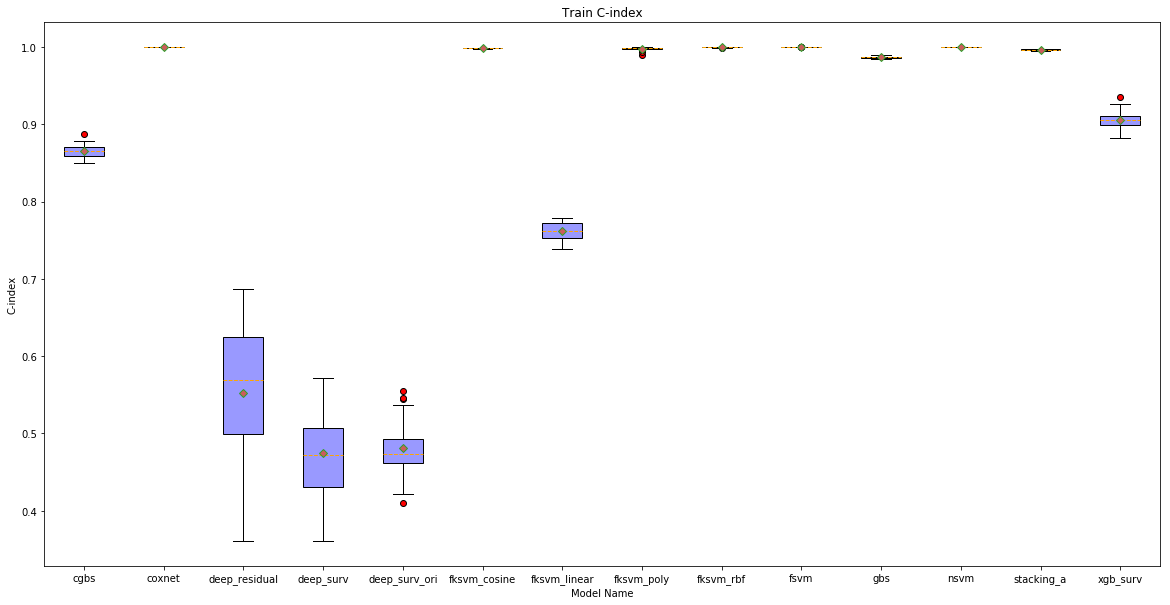

In [47]:
plt.figure(figsize=(20, 10));
plt.title('Train C-index')
plt.xlabel('Model Name')
plt.ylabel('C-index')
plt.boxplot(
    x = boxplot_data["train"],
    patch_artist=True,
    labels = boxplot_data["labels"],
    showmeans=True,
    boxprops = {'color':'black','facecolor':'#9999ff'},
    flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},
    meanprops = {'marker':'D','markerfacecolor':'indianred'},
    medianprops = {'linestyle':'--','color':'orange'}
)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f868d14b3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f868d128780>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f868d14b7f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f868d128f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f868789f2e8>,
 'means': [<matplotlib.lines.Line2D at 0x7f868d5a8278>,
  <matplotlib.lines.Line2D at 0x7f8687914d30>]}

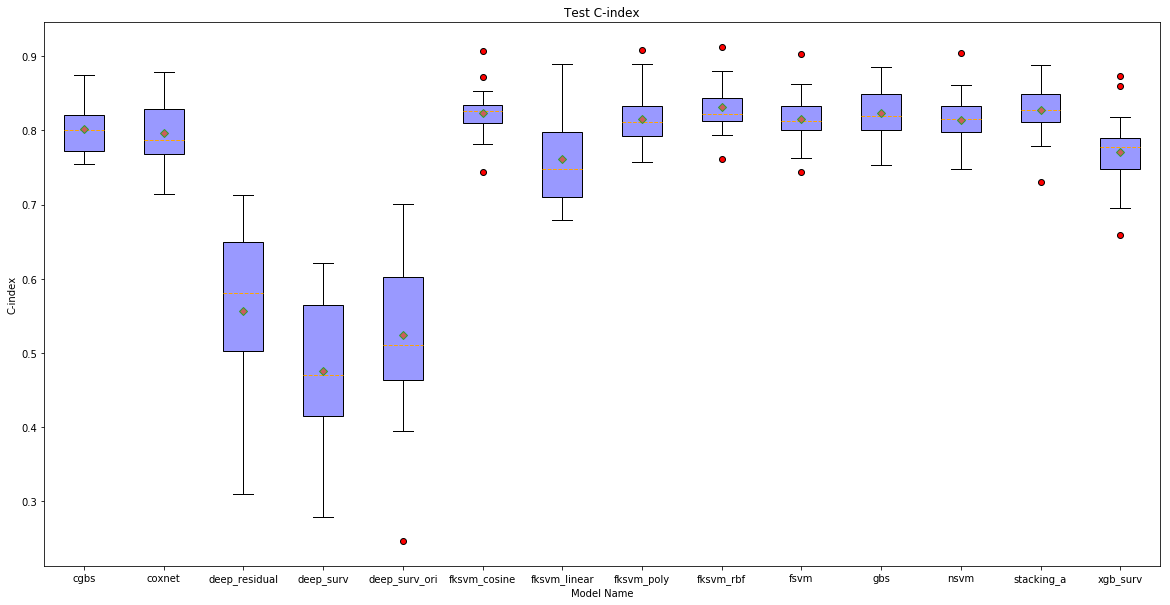

In [48]:
plt.figure(figsize=(20, 10));
plt.title('Test C-index')
plt.xlabel('Model Name')
plt.ylabel('C-index')
plt.boxplot(
    x = boxplot_data["test"],
    patch_artist=True,
    labels = boxplot_data["labels"],
    showmeans=True,
    boxprops = {'color':'black','facecolor':'#9999ff'},
    flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},
    meanprops = {'marker':'D','markerfacecolor':'indianred'},
    medianprops = {'linestyle':'--','color':'orange'}
)